# Memes V/s Notes

In [1]:
# importing stuff
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as functions
import matplotlib.pyplot as plt
if torch.cuda.is_available():
    print('device available')
    device = torch.device('cuda')
else:
    print('device unavailable')
    device = None

device available


## Loading and Visualizing Data

In [5]:
X = np.load('Data/MVN_X.npy')
Y = np.load('Data/MVN_Y.npy')
print(Y[:10])

[0. 1. 0. 0. 0. 1. 0. 1. 0. 1.]


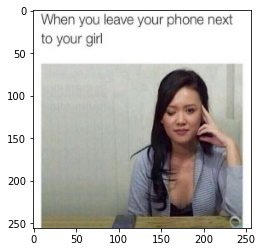

In [6]:
plt.imshow(X[4,:,:,::-1]) #cross-checking

In [7]:
X_test = X[1500:1580]
Y_test = Y[1500:1580]
X_valid = X[1580:1600]
Y_valid = Y[1580:1600]
print(X_test.shape)
print(Y_test[:10])

(80, 256, 256, 3)
[1. 0. 1. 1. 0. 1. 1. 0. 0. 0.]


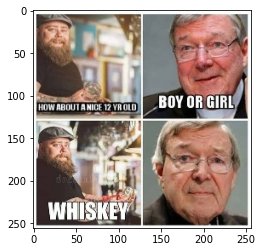

In [8]:
plt.imshow(X_test[4,:,:,::-1]) #cross-checking

In [9]:
X = X[:1500]
Y = Y[:1500]
print(X.shape)
print(Y.shape)

(1500, 256, 256, 3)
(1500,)


In [10]:
# converting all to float and normalizing
X = (X.astype(float))/255
Y = (Y.astype(float))
X_test = (X_test.astype(float))/255
Y_test = (Y_test.astype(float))
X_valid = (X_valid.astype(float))/255
Y_valid = (Y_valid.astype(float))
X = np.transpose(X,(0,3,1,2)) #converting to pytorch format
X_test = np.transpose(X_test,(0,3,1,2))
X_valid = np.transpose(X_valid,(0,3,1,2))
print(X_test.shape)

(80, 3, 256, 256)


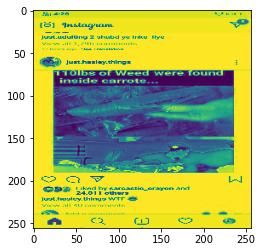

In [11]:
plt.imshow(X[2,0,:,:])

In [12]:
X = torch.from_numpy(X)
Y = torch.from_numpy(Y)
print(type(X))
print(type(Y))

<class 'torch.Tensor'>
<class 'torch.Tensor'>


## Model Building

In [13]:
#MVN2
class MVNNet(nn.Module):
  def __init__(self):
    super(MVNNet,self).__init__()
    self.conv1 = nn.Conv2d(3,96,(11,11),stride=(4,4))
    self.conv2 = nn.Conv2d(96,134,(5,5),stride=(4,4))
    self.conv3 = nn.Conv2d(134,158,(3,3))
    self.fc1 = nn.Linear(158*2*2,252)
    self.fc2 = nn.Linear(252,1)

  def forward(self,x):
    x = functions.relu(self.conv1(x))
    x = functions.relu(self.conv2(x))
    x = functions.max_pool2d(x,(2,2))
    x = functions.relu(self.conv3(x))
    x = functions.max_pool2d(x,(2,2))
    x = x.view(x.size(0),-1)
    x = functions.relu(self.fc1(x))
    x = self.fc2(x)
    return x

In [11]:
net = MVNNet().double()
net.to(device)
optimizer = optim.Adam(net.parameters(),lr=0.001)

In [12]:
total_size = X.size(0)
batchsize = 15
epochs = 3
cost_fn = nn.BCEWithLogitsLoss()
costs = []
epoch_costs = []
for i in range(epochs):
    for j in range(int(total_size/batchsize)):
        optimizer.zero_grad()
        X_minibatch = X[j*batchsize:(j+1)*batchsize].to(device)
        Y_minibatch = Y[j*batchsize:(j+1)*batchsize].to(device)
        output = net(X_minibatch)
        cost = cost_fn(output,Y_minibatch.view(batchsize,1))
        cost.backward()
        optimizer.step()
        costs.append(float(cost.item()))
        if(j == 0):
            epoch_costs.append(cost.item())
        if(j%10 == 0):
            print(str(cost.item())+' at epoch '+str(i),end='  ')
        
            with torch.no_grad():
                valid_output = net(torch.from_numpy(X_valid).to(device))
                valid_output = nn.Sigmoid()(valid_output)
                valid_output = valid_output.cpu().numpy()
                valid_output = (valid_output > 0.5).astype(float)
                valid_output = np.squeeze(valid_output)
                #print(valid_output.shape,Y_valid.shape)
                predictions = (valid_output == Y_valid).astype(float)
                accuracy = np.sum(predictions)/predictions.shape
                print(float(accuracy))
                
        del output
        del X_minibatch
        del Y_minibatch
        del cost
        torch.cuda.empty_cache()
    print('epoch complete')

0.6930142021397239 at epoch 0  0.45
0.6860534456546342 at epoch 0  1.0
1.5137473400444497 at epoch 0  0.95
0.5684803602617317 at epoch 0  0.9
0.08483113188758695 at epoch 0  0.55
0.36957623787681754 at epoch 0  0.45
0.4585848916951402 at epoch 0  0.95
0.22843358691732357 at epoch 0  0.95
0.6300916149549566 at epoch 0  0.95
0.25071158138494626 at epoch 0  1.0
epoch complete
0.02204358999934272 at epoch 1  1.0
4.330080365706356 at epoch 1  0.9
0.6687827110403244 at epoch 1  0.45
0.14906876372930022 at epoch 1  1.0
0.09917775474235663 at epoch 1  1.0
0.14686926768244724 at epoch 1  0.9
0.32339584630735063 at epoch 1  1.0
0.2285697085209463 at epoch 1  1.0
0.016242087325507314 at epoch 1  1.0
0.10012956526998652 at epoch 1  0.95
epoch complete
0.044384203838861276 at epoch 2  1.0
0.2741712592815204 at epoch 2  1.0
0.5744866615985534 at epoch 2  1.0
0.013035212294690863 at epoch 2  1.0
0.0608870262877461 at epoch 2  0.95
0.3318863585345005 at epoch 2  0.95
0.208178108167489 at epoch 2  0.95

300
0.03577752032674817
[0.6930142021397239, 0.02204358999934272, 0.044384203838861276]


Text(0.5, 1.0, 'Cost per iteration')

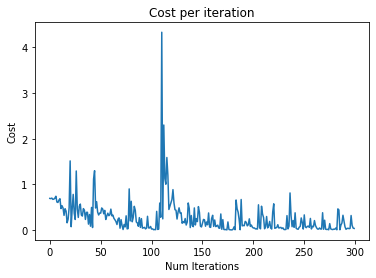

In [13]:
print(len(costs))
print(costs[-1])
print(epoch_costs)
plt.plot(costs)
plt.ylabel('Cost')
plt.xlabel('Num Iterations')
plt.title('Cost per iteration')

In [14]:
# saving
torch.save(net.state_dict(),'MVN4.pth')

In [14]:
# loading
net = MVNNet().double()
net.load_state_dict(torch.load('MVN2.pth'))
net.to(device)

MVNNet(
  (conv1): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
  (conv2): Conv2d(96, 134, kernel_size=(5, 5), stride=(4, 4))
  (conv3): Conv2d(134, 158, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=632, out_features=252, bias=True)
  (fc2): Linear(in_features=252, out_features=1, bias=True)
)

## Checking Training Accuracy

In [12]:
torch.cuda.empty_cache()
with torch.no_grad():
    for j in range(int((1500/15))):
        train_results_temp = net(X[j*15:(j+1)*15].to(device))
        train_results_temp = nn.Sigmoid()(train_results_temp)
        train_results_temp = train_results_temp.cpu().numpy()
        train_results = train_results_temp if (j == 0) else np.concatenate((train_results,train_results_temp))
        del train_results_temp
    train_labels = Y.cpu().numpy()
print(train_results.shape)
print(train_labels.shape)

(1500, 1)
(1500,)


In [13]:
print(train_results.shape)
train_results = np.squeeze(train_results)
print(train_results[:10])

(1500, 1)
[1.60560436e-10 9.22219378e-01 1.47080644e-14 1.81957499e-09
 6.37079344e-04 9.73593939e-01 1.53353572e-02 8.93033726e-01
 2.11002309e-06 9.54408992e-01]


In [14]:
train_results = (train_results > 0.5).astype(float)
print(train_results[:10])
print('these are train labels')
print(train_labels[:10])
predictions = (train_results == Y.cpu().numpy()).astype(float)
accuracy = (np.sum(predictions))/(predictions.shape)
print(float(accuracy*100))

[0. 1. 0. 0. 0. 1. 0. 1. 0. 1.]
these are train labels
[0. 1. 0. 0. 0. 1. 0. 1. 0. 1.]
97.8


## Checking Test Set accuracy

In [15]:
X_test = torch.from_numpy(X_test)

In [16]:
print(X_test.shape)

torch.Size([80, 3, 256, 256])


In [17]:
torch.cuda.empty_cache()
with torch.no_grad():
    test_results = net(X_test.to(device))
    test_results = nn.Sigmoid()(test_results)
    test_results = test_results.cpu().numpy()
    #test_labels = Y_test.numpy()
test_results = np.squeeze(test_results)
print(test_results.shape)
print(Y_test.shape)
print(test_results[:10])

(80,)
(80,)
[9.39950279e-01 2.34113175e-11 8.96644246e-01 8.91052853e-01
 6.70579041e-05 9.33653501e-01 9.28624871e-01 9.47906403e-13
 1.74790950e-08 4.13408848e-21]


In [18]:
test_results = (test_results > 0.5).astype(float)
print(test_results[:10])
print('these are train labels')
print(Y_test[:10])
predictions = (test_results == Y_test).astype(float)
accuracy = (np.sum(predictions))/(predictions.shape)
print(float(accuracy*100))

[1. 0. 1. 1. 0. 1. 1. 0. 0. 0.]
these are train labels
[1. 0. 1. 1. 0. 1. 1. 0. 0. 0.]
100.0


## Free Checking

tensor([[-4131.6017]], device='cuda:0', dtype=torch.float64)
its a meme (100.0% sure)


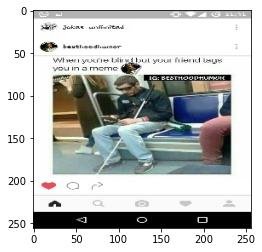

In [20]:
index = 120 # change this to change image
images = np.load('Data/MVN_X.npy')
tensors = np.transpose(images,(0,3,1,2))
tensors = torch.from_numpy(tensors[index].reshape(1,3,256,256)).double()
with torch.no_grad():
    result = net(tensors.to(device))
    print(result)
    result = nn.Sigmoid()(result)
  #result = 1 if (result > 0.5) else 0
plt.imshow(images[index,:,:,::-1])
if(result > 0.5):
  print('these are notes ('+str(result.item()*100)+'% sure)')
else:
  print('its a meme ('+str((1-result.item())*100)+'% sure)')

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as functions

In [5]:
net = MVNnet = MVNNet()
net.load_state_dict(torch.load('MVN2.pth'))
net.eval()
script_model = torch.jit.trace(net,torch.rand(1,3,256,256))
script_model.save("MVN_Mobile.pt")